Problem 4: Handwritten Digits

In [17]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import math
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from statistics import mode

In [2]:
# Import the MNIST dataset
data = np.float64(np.load('/Users/weixinyu/Desktop/cs25025/MNIST.npy'))
labels = np.float32(np.load('/Users/weixinyu/Desktop/cs25025/MNIST_labels.npy'))

# Normalize the data
data = data/255

In [3]:
# Divide the data into training, testing, and development
training = data[0:int(70000*0.6)]
training_label = labels[0:int(70000*0.6)]
dev = data[int(70000*0.6):int(70000*0.8)]
dev_label = labels[int(70000*0.6):int(70000*0.8)]
test = data[int(70000*0.8):]
test_label = labels[int(70000*0.8):]

PART I PCA

(a) Extract principal components

In [4]:
# Center the training data
train_center = training.mean(0)
train_centered = training - train_center

# Get the covariance matrix of the training data
S = (1/train_centered.shape[0])*np.dot(np.transpose(train_centered),train_centered)

In [5]:
# Compute eigenvalues and eigen vectors of S
w_train, v_train = LA.eigh(S)

# Select the last 10 eigenvectors
V_train_10 = np.array(v_train[:,-10:])

In [6]:
# First 10 principal components
pc_10 = np.dot(train_centered, V_train_10)

# Represent the training data with first 10 principal components
# Add back the center
X_pc = np.dot(pc_10, V_train_10.transpose())
X_pc = X_pc + train_center

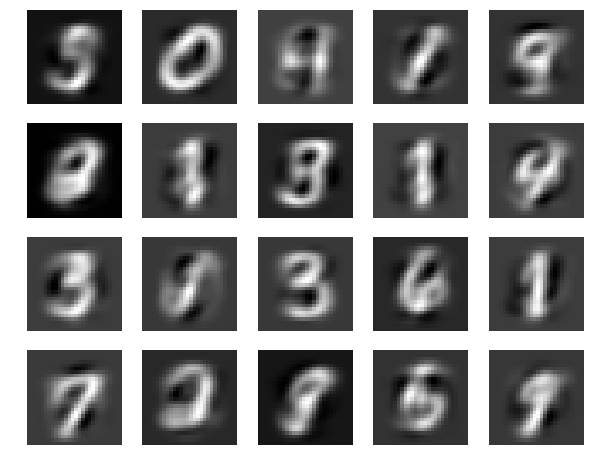

In [7]:
# Display the first 10 principal components as images
nrows = 4
ncols = 5
plt.figure(figsize=(ncols*2, nrows*2))
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(X_pc[i].reshape((28,28)), cmap="gray")
    plt.axis("off")
plt.axis("off")
plt.show()

(b) Plot variance

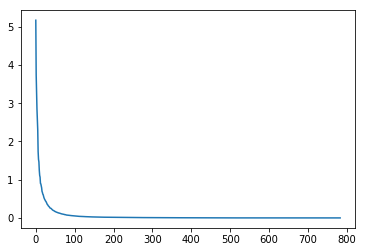

In [8]:
# The variance of the ith principal component is the ith eigenvalue of S
plt.plot(np.flip(w_train, 0))

(c) Dimension reduction

In [9]:
# Funtion dim_reduction
# Takes a data point, projects it onto the first m principal components, transforms 
# the m-length vector back into a 784-length vector and displays it as an image
def dim_reduction(m,x):
    cen = x - train_center
    V = np.array(v_train[:,-m:])
    est = np.dot(cen, np.dot(V, V.transpose()))
    est = est + train_center
    plt.imshow(est.reshape((28,28)), cmap="gray")
    plt.axis("off")
    plt.show()

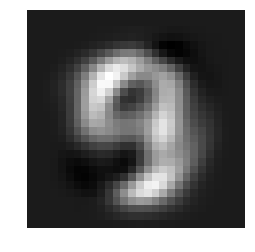

In [10]:
dim_reduction(3,test[4])

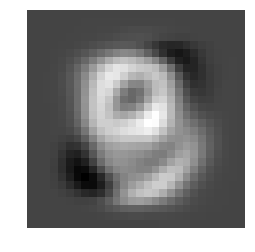

In [11]:
dim_reduction(10,test[4])

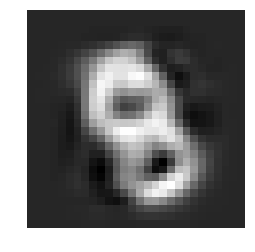

In [12]:
dim_reduction(50,test[4])

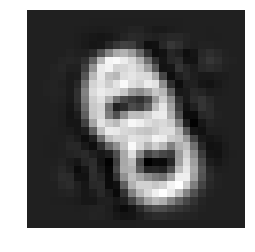

In [13]:
dim_reduction(100,test[4])

The image is not recognizable when m is less than 10. The image could look like something different than the actual digit. For example here when m=3 the image looks like 9 but it is actually 8. When m=10, the digit could be recognized but is very vague. As m increases, the shape and edge of the digits is clearer and the contrast with the background is higher. The top principal components are capturing the main structure and feature of the image. As m goes higher, sharper details of the edges are shown.

PART II K_MEANS

In [14]:
# Set the number of clusters
num_cluster = 10

# Perform k-means on training data
kmeans = KMeans(n_clusters=num_cluster).fit(training)
cluster = kmeans.predict(training)
cluster

array([2, 4, 0, ..., 8, 8, 4], dtype=int32)

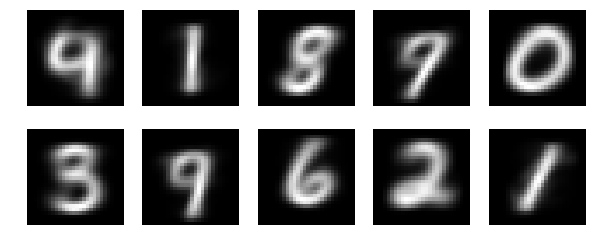

In [15]:
# Show the centers of the clusters
C = kmeans.cluster_centers_
nrows = 2
ncols = 5
plt.figure(figsize=(ncols*2, nrows*2))
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(C[i].reshape((28,28)), cmap="gray")
    plt.axis("off")
plt.axis("off")
plt.show()

In [21]:
# Find the majority label of each cluster
indices = np.array([np.where(cluster == i)[0] for i in range(num_cluster)])
label_clusters = np.array([labels[indices[i]] for i in range(num_cluster)])
majority_label = [(i, int(mode(label_clusters[i]))) for i in range(num_cluster)]
majority_label_df = pd.DataFrame(majority_label, columns = ['Cluster', 'Majority Label'])
majority_label_df

,Cluster,Majority Label
0,0,4
1,1,1
2,2,8
3,3,7
4,4,0
5,5,3
6,6,9
7,7,6
8,8,2
9,9,1


In [26]:
cluster

array([2, 4, 0, ..., 8, 8, 4], dtype=int32)

In [28]:
# Map cluster number to the cluster's prediction
pred_value = np.copy(cluster)
for l in majority_label:
    ind = np.array([np.where(cluster == l[0])[0] for i in range(num_cluster)])
    np.put(pred_value, ind, l[1])

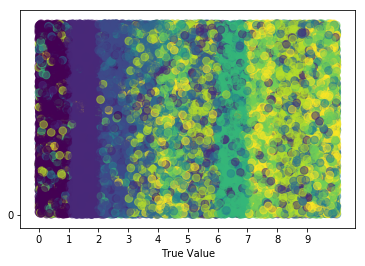

In [29]:
# Plot showing samples of the digits from each cluster
x = labels[:42000] + np.random.rand(42000)
y = np.random.rand(cluster.shape[0])
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0,1))
plt.scatter(x, y, alpha = 0.5, s = 60, c = pred_value)
plt.xlabel("True Value")
plt.show()

The plot above shows the samples of digits from each cluster. The x-axis is the label of each digits, and the y-axis is random scattering of the points of same label. I also added some randomness to the x-axis so that the points could randomly scatter on the interval of (label, label+1). So a sample of label 1 could be anywhere between 1 and 2 along the x-axis, and a sample of label 2 could be anywhere between 2 and 3, and so forth. The points of same colors are from the same cluster. Overall, the cluster captures the true value of the digits well, as most of the digits with same label are in the same cluster (same color). The cluster does an especially good job with digit 0,1, 2, and 6. Digits 3, 4, and 5 are clustered a little messy. 

PART III Spectral Clustering

In [30]:
data1000 = data[:1000]

In [31]:
labels1000 = labels[:1000]

In [32]:
# Construct the similarity matrix A
# Choose h = 0.01 so that the first few eigenvalues are the smallest
A = sklearn.metrics.pairwise.rbf_kernel(data1000, gamma = 0.01)

In [33]:
# Compute the diagonal matrix D and D(-1/2)
row_sum = A.sum(axis = 1)
row_sum_p = np.power(row_sum, -1/2)
D_p = np.diag(row_sum_p)

In [34]:
# Compute the normalized graph Laplacian matrix
# L = I − W  = I − D − 1 / 2 W D − 1 / 2
I = np.identity(A.shape[0])
L = I - np.dot(np.dot(D_p, A), D_p)

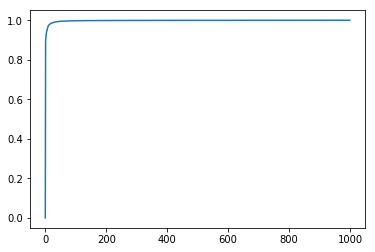

In [35]:
# Compute the eigenvalues and eigenvectors of L
eigval, eigvec = LA.eigh(L)
plt.plot(eigval)

In [36]:
# Choose the reduced dimension r
r = 3
Vr = eigvec[:,1:r+1]

In [37]:
# Perform k-means
spec_kmeans = KMeans(n_clusters=num_cluster).fit(Vr)
spec_cluster = spec_kmeans.predict(Vr)

In [39]:
# Find the majority label of each cluster
spec_indices = np.array([np.where(spec_cluster == i)[0] for i in range(num_cluster)])
spec_label_clusters = np.array([labels1000[spec_indices[i]] for i in range(num_cluster)])
spec_majority_label = [(i, int(mode(spec_label_clusters[i]))) for i in range(num_cluster)]

# Map the cluster number to the predicted value
spec_pred_value = np.copy(spec_cluster)
for l in spec_majority_label:
    spec_ind = np.array([np.where(spec_cluster == l[0])[0] for i in range(num_cluster)])
    np.put(spec_pred_value, spec_ind, l[1])

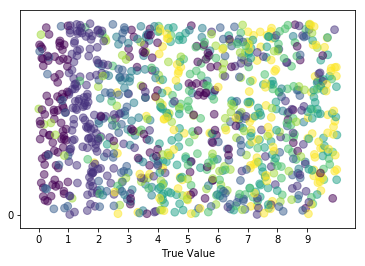

In [40]:
# Plot showing samples of the digits from each cluster
spec_x = labels[:1000] + np.random.rand(1000)
spec_y = np.random.rand(spec_cluster.shape[0])
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0,1))
plt.scatter(spec_x, spec_y, alpha = 0.5, s = 60, c = spec_pred_value)
plt.xlabel("True Value")
plt.show()

Compared to the result from standard k-means, the cluster possess a similar quality of representing the true label of the digits, suggesting that the low dimension representation is able to capture the main feature of the data.

PART IV Classification

(a) Multinomial logistic regression 

In [41]:
# Run the logistic Regression
lg = LogisticRegression(fit_intercept=True, C=100000, penalty="l2", multi_class="multinomial",solver="lbfgs")
classi = lg.fit(training, training_label)

In [42]:
# Evaluate the model on development set, and calculate the error rate
pred = classi.predict(dev)
err = sum([int(pred[i] != dev_label[i]) for i in range(pred.shape[0])])/pred.shape[0]

In [44]:
err

0.08807142857142858

(b) Logistic regression with top k principal components

In [45]:
# Train multinomial logistic regression model on training data, using the top k principal components
k = 10
Vk = np.array(v_train[:,-k:])
training_pc = np.dot(train_centered, Vk)
classi_pc = lg.fit(training_pc, training_label)

In [46]:
# Predict the labels of the development data
centered_dev = dev - train_center
dev_pc = np.dot(centered_dev, Vk)
pred_pc = classi_pc.predict(dev_pc)

In [47]:
# Compute the error rate
err_pc = sum([int(pred_pc[i] != dev_label[i]) for i in range(pred_pc.shape[0])])/pred_pc.shape[0]

In [48]:
err_pc

0.21221428571428572

In [49]:
# Compute the error rate as a function of k
def err_k(k):
    Vk = np.array(v_train[:,-k:])
    training_pc = np.dot(train_centered, Vk)
    classi_pc = lg.fit(training_pc, training_label)
    dev_pc = np.dot(centered_dev, Vk)
    pred_pc = classi_pc.predict(dev_pc)
    err_pc = sum([int(pred_pc[i] != dev_label[i]) for i in range(pred_pc.shape[0])])/pred_pc.shape[0]
    print(k)
    print(err_pc)
    return err_pc

In [168]:
# Plot the error as a function of k
err_k = [err_k(i) for i in range(0, v_train.shape[1]+28, 28)]

0
0.09364285714285714
28
0.12007142857142857
56
0.09728571428571428
84
0.09278571428571429
112
0.0895
140
0.0885
168
0.08728571428571429
196
0.08707142857142858
224
0.0875
252
0.08792857142857143
280
0.08935714285714286
308
0.08892857142857143
336
0.09
364
0.09107142857142857
392
0.0905
420
0.091
448
0.09214285714285714
476
0.09271428571428571
504
0.09228571428571429
532
0.09407142857142857
560
0.09407142857142857
588
0.09328571428571429
616
0.09357142857142857
644
0.09378571428571429
672
0.09357142857142857
700
0.09357142857142857
728
0.09364285714285714
756
0.09364285714285714
784
0.09364285714285714


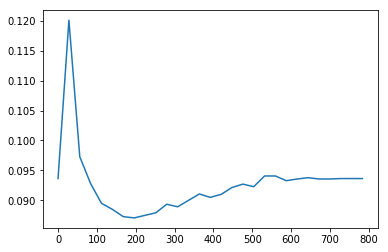

In [169]:
err_k_xaxis = [i for i in range(0, v_train.shape[1]+28, 28)]
plt.plot(err_k_xaxis, err_k)

As k increases to around 50, the error jumps to the highest value. Then it decreases as the k continue to increase and reach the minimum when k is around 200. The error then increases as k increases all the way to 784. This is because when k is very small, the principal components could not capture the features of the data well, so the erre rate is very high. As k continue to increase to an appropriate level, the appropriate number of principal component could capture the data very well and minimize the error rate. As k continue to go higher, more details are added in and because of overfitting, the error rate is slightly lifted.

(c) Retrain the model with optimal k

180
0.08842857142857143
181
0.08842857142857143
182
0.08707142857142858
183
0.0875
184
0.08692857142857142
185
0.08714285714285715
186
0.08735714285714286
187
0.08614285714285715
188
0.08642857142857142
189
0.08621428571428572
190
0.08614285714285715
191
0.08657142857142858
192
0.08628571428571429
193
0.08735714285714286
194
0.08707142857142858
195
0.08671428571428572
196
0.08707142857142858
197
0.08714285714285715
198
0.08728571428571429
199
0.08678571428571429


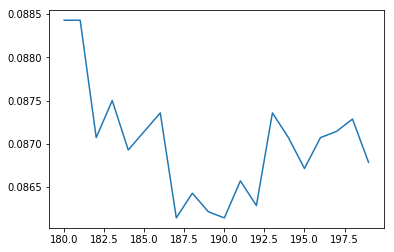

In [172]:
# Narrow the search for the optimum k
err_k_narrowed = [err_k(i) for i in range(180, 200)]
err_k_xaxis_narrowed = [i for i in range(180, 200)]
plt.plot(err_k_xaxis_narrowed, err_k_narrowed)

In [173]:
# Find the optimum k
opt_k = err_k_xaxis_narrowed[np.argmin(err_k_narrowed)]

In [174]:
opt_k

187

In [181]:
# Retrain the model using both training and development data
V_opt_k = np.array(v_train[:,-opt_k:])

# Prepare data
train_dev = np.concatenate((training, dev), axis=0)
train_dev_centered = train_dev - train_center
train_dev_label = np.concatenate((training_label, dev_label), axis=0)
train_dev_pc = np.dot(train_dev_centered, V_opt_k)

# Run logistic regression and make prediction on test data
train_dev_classi = lg.fit(train_dev_pc, train_dev_label)
test_centered = test - train_center
test_pc = np.dot(test_centered, V_opt_k)  
train_dev_pred = classi_pc.predict(test_pc)

In [182]:
# Compute the error rate on testing data
test_err = sum([int(train_dev_pred[i] != test_label[i]) for i in range(train_dev_pred.shape[0])])/train_dev_pred.shape[0]

In [183]:
test_err

0.06685714285714285

The error rate (0.06685714285714285) is smaller compared to the error rate (0.08807142857142858) using raw features. This is because a) the use of appropriate number of principal components can alleviate the issue of overfitting, and b) we trained and developed the model with training and development data, found the optimal number of principal components to use, so the error rate on the test data should be reduced.